## Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
display(visits.head(), orders.head(), costs.head()) #выводим первые строки с нашими данными

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
# ищем пропуски в данных
print(visits.isna().sum())
print(orders.isna().sum())
print(costs.isna().sum())

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
User Id     0
Event Dt    0
Revenue     0
dtype: int64
dt         0
Channel    0
costs      0
dtype: int64


In [5]:
# поиск дубликатов
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


In [6]:
#приводим названия колонок к принятому виду 
visits.columns = visits.columns.str.lower().str.replace(' ','_')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
#приводим названия колонок к принятому виду 
orders.columns = orders.columns.str.lower().str.replace(' ','_')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
#приводим названия колонок к принятому виду
costs.columns = costs.columns.str.lower()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
# приводим сохраненные данные к соответствующему типу данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [10]:
# приводим сохраненные данные к соответствующему типу данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [11]:
# приводим сохраненные данные к соответствующему типу данных
# добавляем колонки с месяцем и неделей
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

In [12]:
(
    orders[['revenue']]
    .apply (['count', 'min', 'max']) 
    .style.format("{:,.2f}")
)

,revenue
count,"40,212.00"
min,4.99
max,49.99


In [13]:
(
    costs[['costs']]
    .apply (['count', 'min', 'max']) 
    .style.format("{:,.2f}")
)

,costs
count,"1,800.00"
min,0.80
max,630.00


**Вывод:**
В ходе подготовки к анаоизу мы рровели предобработку данных, изучили информацию, содержащуюся в данных, привели названия столбцов к надлежащему виду, а также привели типы данных некоторых столбцов в соответствие с информацией в них.

## Создание функции для расчёта и анализа LTV, ROI, удержания и конверсии.

### Функции для вычисления значений метрик

In [14]:
# функция создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )


    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [15]:
# функция подсчета коэффициента удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [16]:
# функция подсчета коэффициента конверсии пользователей
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [17]:
# функция подсчета пожизненной ценности пользователей
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date and channel != "organic"')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped, 
        roi_in_time,  
    ) 

Создали необходимые функции для расчет значений метрик удержания, конверсии, LTV, ROI и CAC.

### Функции для построения графиков

In [18]:
# функция сглаживания данных
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [19]:
# функция создания кривых удержания и графика динамики удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [20]:
# функция создания кривых конверсии и графика динамики конверсии 
def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [21]:
# функция визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Написали функции для визуализации значений нужных метрик.

## Исследовательский анализ данных

### Профили пользователей 

In [22]:
# составляем профили пользователей и выводим первые 5 строк
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Составили профили пользователей, в которые входят их уникальные обозначения, а также другие характеристики, включая то, конвертировались ли они в покупателя.

In [23]:
# определяем минимальную и максимальную даты привлечения пользователей
min_data = profiles['dt'].min()
print(min_data)
max_data = profiles['dt'].max()
print(max_data)

2019-05-01
2019-10-27


Определили минимальную и максимальную даты привлечения пользователей, которые согласуются с условиями поставленной задачи. 

### Количество пользователей и доля платящих из каждой страны

In [24]:
# создаем таблицу распределения платящих пользователей по странам и их доля для каждой страны 
client_share = profiles.groupby('region')['user_id'].nunique() # группируем уникальных пользователей по странам
client_share = pd.DataFrame(client_share) # создаем отдельный датафрейм для удобства работы
client_share = client_share.rename({'user_id' : 'users_total'}, axis='columns')
p = profiles.query('payer == True').groupby('region')['user_id'].nunique() # отфильтруем платящих пользователей и сгруппируем
client_share['paying_users'] = p # создание отдельного столбца для платящих пользователей
client_share['share'] = round((client_share['paying_users'] / client_share['users_total']) * 100, 2) # доля платящих
client_share.sort_values(by='share', ascending=False).style.format({'share':'{:.2f}%'})

,users_total,paying_users,share
region,,,
United States,100002,6902,6.90%
Germany,14981,616,4.11%
UK,17575,700,3.98%
France,17450,663,3.80%


Вывели таблицу с общим числом пользователей из стран, а также долю платящих пользователей для каждой страны. Можно видеть, что большая часть пользователей приложения из Америки. Более того, Американские пользователи чаще становятся платящими.

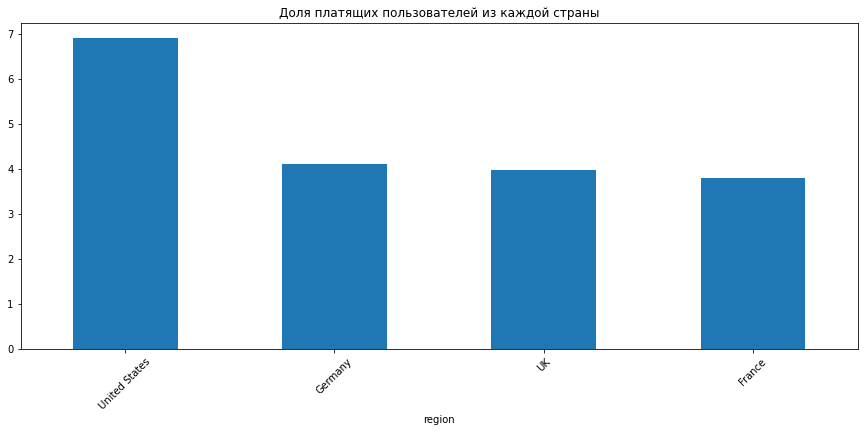

In [25]:
# диаграмма, отражающая долю платящих пользователей из общего числа для каждой из стран
client_share.sort_values(by='share', ascending=False).plot(kind='bar',
                  figsize=(15, 6),
                  y='share',
                  legend=False,
                  rot = 45,
                 title = 'Доля платящих пользователей из каждой страны');

Диаграмма показывает разницу доли платящих пользователей в разных странах.

### Количество пользователей и доля платящих по девайсу

In [26]:
device_share = profiles.groupby('device')['user_id'].nunique()
device_share = pd.DataFrame(device_share)
device_share = device_share.rename({'user_id' : 'users_total'}, axis='columns')
p = profiles.query('payer == True').groupby('device')['user_id'].nunique()
device_share['paying_users'] = p
device_share['share'] = round((device_share['paying_users'] / device_share['users_total']) * 100, 2)
device_share.sort_values(by='share', ascending=False).style.format({'share':'{:.2f}%'})

,users_total,paying_users,share
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


Большинство пользователей используются мобильные устройства для работы с приложением. При этом можно заметить, что пользователи девайсов Apple конвертируются больше, чем пользователи на других устройствах.

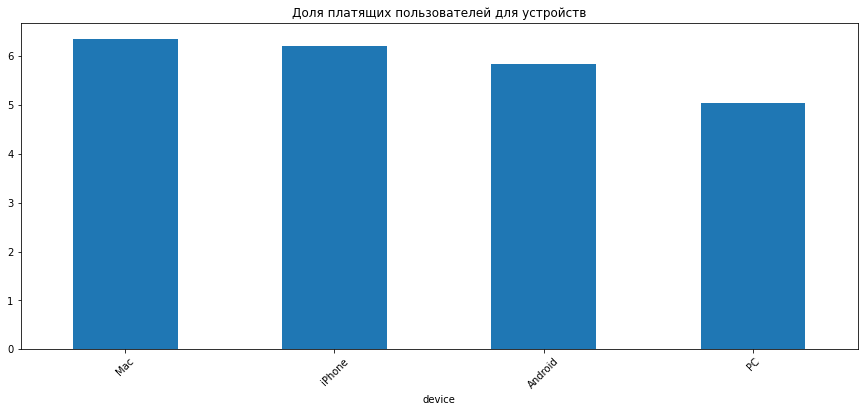

In [27]:
# диаграмма, описывающая долю платящих пользователей для каждого устройства
device_share.sort_values(by='share', ascending=False).plot(kind='bar',
                  figsize=(15, 6),
                  y='share',
                  legend=False,
                  rot = 45,
                  title = 'Доля платящих пользователей для устройств');

На диаграмме видно, что доля платящих пользователей на устройствах Mac и iPhone почти идентичны. Доля платящих пользователей на ПК самая маленькая в данной выборке.

### Количество пользователей и доля платящих из каждой источника

In [28]:
ad_share = profiles.groupby('channel')['user_id'].nunique()
ad_share = pd.DataFrame(ad_share)
ad_share = ad_share.rename({'user_id' : 'users_total'}, axis='columns')
p = profiles.query('payer == True').groupby('channel')['user_id'].nunique()
ad_share['paying_users'] = p
ad_share['share'] = round((ad_share['paying_users'] / ad_share['users_total']) * 100, 2)
ad_share.sort_values(by='share', ascending=False).style.format({'share':'{:.2f}%'})

,users_total,paying_users,share
channel,,,
FaceBoom,29144,3557,12.20%
AdNonSense,3880,440,11.34%
lambdaMediaAds,2149,225,10.47%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%


Очень много пользователей пришло через каналы "FaceBoom" и "TipTop". Самая большая доля платящих пользователей у платформы "FaceBoom". Однако, больше всего пользователей пришло органическим путём, хотя из только 2% перешли в платящих.

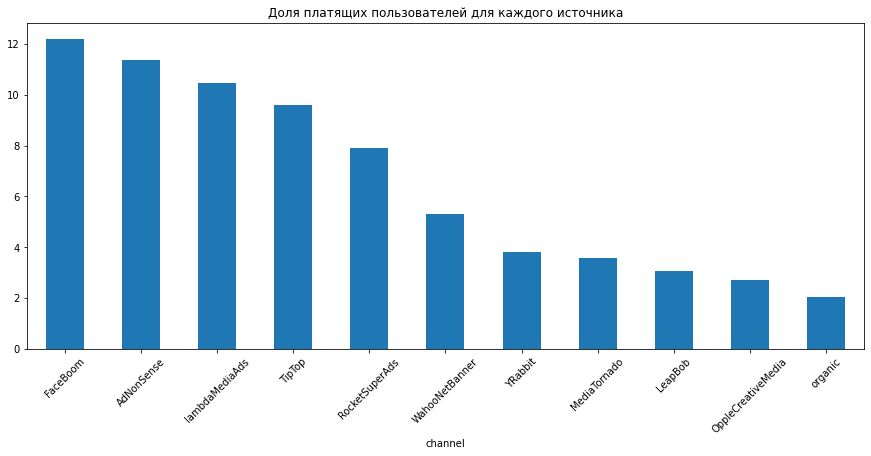

In [29]:
# диаграмма доли платящих пользователей для каждого источника привлечения новых пользователей
ad_share.sort_values(by='share', ascending=False).plot(kind='bar',
                  figsize=(15, 6),
                  y='share',
                  legend=False,
                  rot = 45,
                  title = 'Доля платящих пользователей для каждого источника');

На диаграмме выделяется пятерка источников, у которых доля платящих пользователей является самой большой.

**Вывод:**
В ходе исследовательского анализа данных были составлены профили пользователей. С их помощью были созданы таблицы распределения обычных пользователей и платящих пользователей по странам, по устройствам и по каналам привлечения, а также подсчитана доля платящих пользователей из общего числа по каждому параметру. Самая большая доля платящих пользователей характерна для США - 6.90%, там же находится большинство пользователей приложения - более 100 000. Доли платящих пользователей, использующих iPhone и Mac самые большие - 6.36% и 6.21%. Большинство пользователей пользуются мобильными устройствами, в частности iPhone пользуется более 54 000. Самыми крупными платформами, которые принесли больше всего пользователей являются - FaceBoom и TipTop.
Через них пришло 29144 и 19651  пользователей. Доля платящих пользователей, пришедших из FaceBoom самая высокая - 12.20%. Далее AdNonSense и lambdaMediaAds с 11.34% и 10.47% соответственно. Стоит отметить, что они принесли значительно меньше пользователей - 3880 и 2149.
Минимальной и максимальной датой анализа были определены 01.05.2019 и 27.10.2019 соответственно.

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

### Общие затраты, распределение трат по источникам и динамика изменения расходов

In [30]:
# подсчет общей суммы, затраченной на рекламу
round(costs['costs'].sum(), 2)

105497.3

Общие затраты на маркетинг составили - 105497.3.

In [31]:
# распределение трат по рекламным источникам
costs.groupby('channel').agg({'costs' : 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего средств было вложено в рекламу на платформе "TipTop" - 54751.30 и в рекламу на платформе "FaceBoom" - 32445.60.

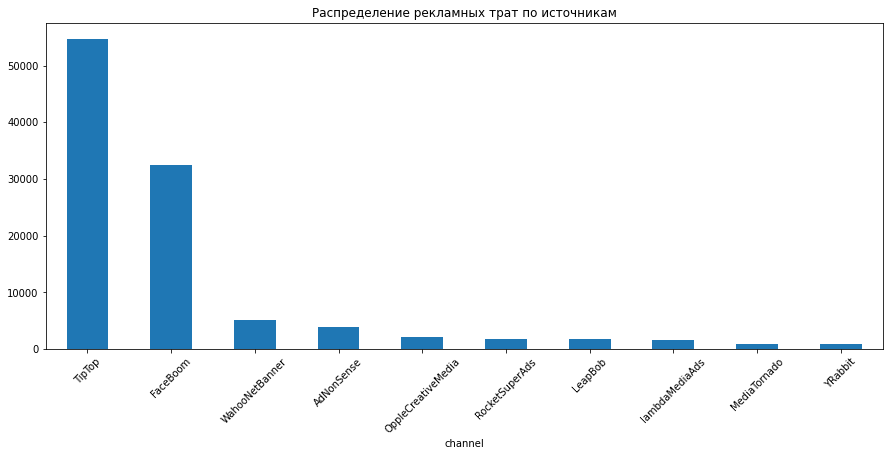

In [32]:
costs.groupby('channel').agg({'costs' : 'sum'}).sort_values(by='costs', ascending=False).plot(kind='bar',
                  figsize=(15, 6),
                  y='costs',
                  legend=False,
                  rot = 45,
                  title = 'Распределение рекламных трат по источникам');

На графике заметная большая разница в распределении средств между источниками.

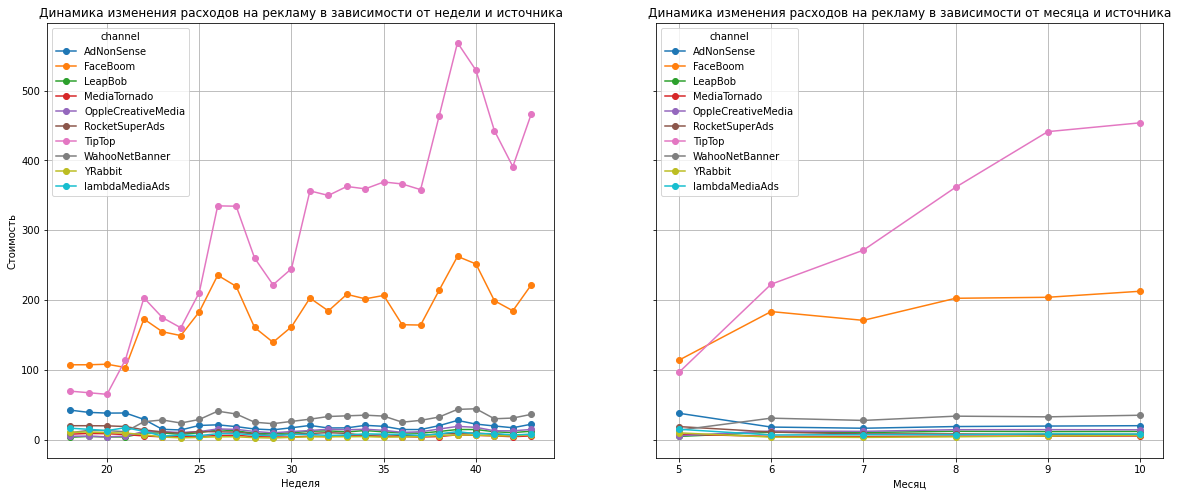

In [33]:
# динамика изменения расходов на маркетинг по неделям и месяцам
dynamic_costs = costs.pivot_table(index='week', columns='channel', values='costs')
ax1 = plt.subplot(1,2,1)
dynamic_costs.plot(grid=True, figsize=(20, 8), marker='o', ax=ax1)
plt.title('Динамика изменения расходов на рекламу в зависимости от недели и источника')
plt.xlabel('Неделя')
plt.ylabel('Стоимость')

dynamic_costs = costs.pivot_table(index='month', columns='channel', values='costs')
ax2 = plt.subplot(1,2,2, sharey=ax1)
dynamic_costs.plot(grid=True, figsize=(20, 8), marker='o', ax=ax2)
plt.title('Динамика изменения расходов на рекламу в зависимости от месяца и источника')
plt.xlabel('Месяц')
plt.ylabel('Стоимость')
plt.show()

Динамика расходов большинства источников на протяжении всего анализируемого периода оставалась практически неизменной. Очень сильно менялись расходы на рекламу в "TipTop" и "FaceBoom". На недельном графике динамика роста нестабильна. Сильно друг от друга отличаются "TipTop" и "FaceBoom" по темпам роста. Траты на "TipTop" изначально были меньше, чем на "FaceBoom". Однако, затем на фоне их общего резкого роста особенно выделился "TipTop". К 43 неделе несмотря на падения, траты на "TipTop" выросли в несколько раз. Траты на "FaceBoom" выросли не так сильно, но все равно значительно по сравнению с другими каналами. На графикие динамики по месяцам рост показан плавнее, на нем видно, что максимума стоимость рекламы в "TipTop" достигла в октябре.

### Средняя стоимость привлеченного пользователя по источникам


In [34]:
# Рассчет средней стоимости привлечения пользователя по каждому источнику
acquisition_mean = profiles.query('channel != "organic"') # делаем срез без пользовтелей, пришедших самостоятельно
#считаем среднюю стоимость
channel_mean = acquisition_mean.\
groupby('channel').agg({'acquisition_cost' : 'mean'}).sort_values(by='acquisition_cost', ascending=False)
channel_mean

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [35]:
channel_mean.mean()

acquisition_cost    0.755735
dtype: float64

Средняя стоимость одного пользователя, привлеченного через "TipTop" составляет ~ 2.8, что является максимумом среди всех источников. Средняя стоиомость привлечения в "FaceBoom" в 2 раза меньше ~ 1.1. Средняя же стоимость среди всех анализируемых источников составила - 0.75.

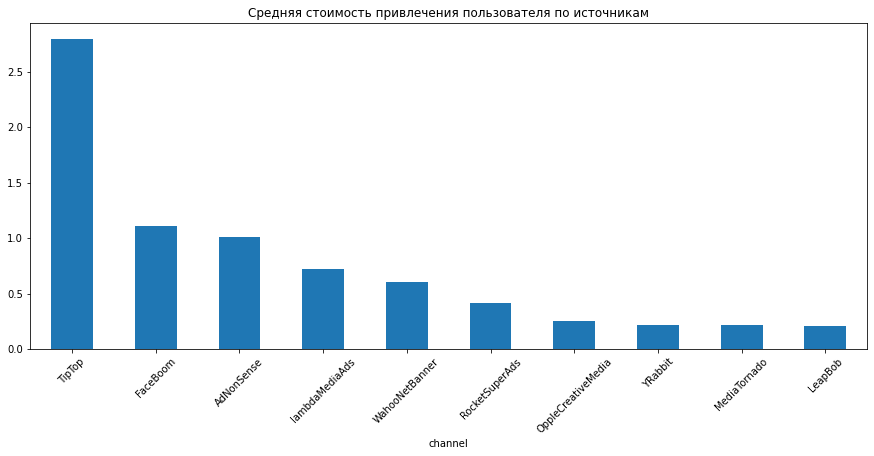

In [36]:
acquisition_mean.groupby('channel').agg({'acquisition_cost' : 'mean'}).sort_values(by='acquisition_cost', ascending=False).plot(
    kind='bar',
    figsize=(15, 6),
    y='acquisition_cost',
    legend=False,
    rot = 45,
    title = 'Средняя стоимость привлечения пользователя по источникам');

Можно видеть как сильно выделяется TipTop на фоне других источников.

**Вывод:** Всего на рекламу было затрачено - 105497.3, больше всего средств было выделено на "TipTop" и "FaceBoom" - 54751.30 и 32445.60 соответственно. На графике развития стоимости рекламы по неделям динамика неравномерна, испытывает резкие падения и повышения. На грфике развития стоимости рекламы по месяцами динамика плавно повышается без резких падений и повышений. Самая высокая средняя стоимость привлечения пользователей характерна для "TipTop" - 2.8. В среднем по всем источникам стоимость привлечения составляет - 0.75.

## Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Анализ окупаемость рекламы по графикам LTV, CAC и ROI, конверсия и удержание пользователей


In [37]:
observation_date = datetime(2019, 11, 1).date() # дата анализа
horizon_days = 14

In [38]:
# рассчитаем LTV, ROI и CAC
ltv_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, horizon_days)

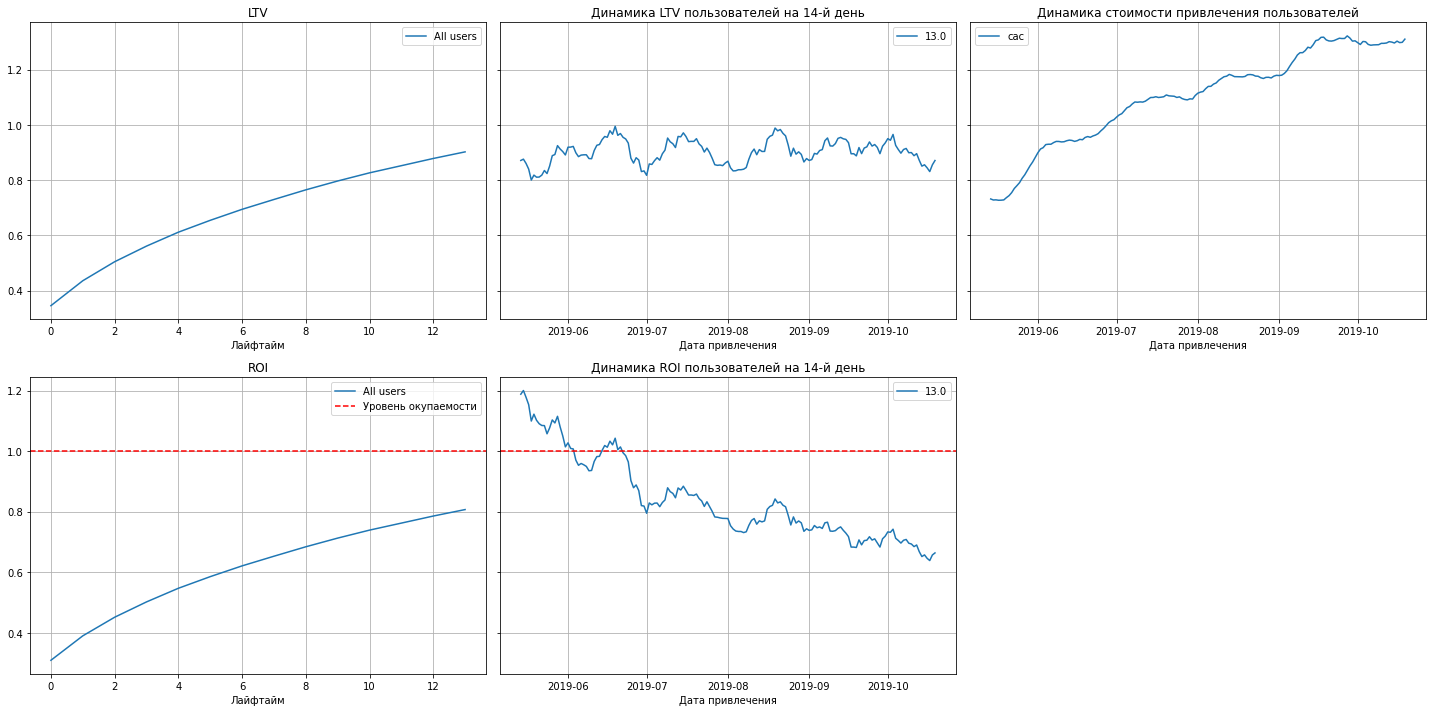

In [39]:
# выведем графики LTV, ROI и CAC
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, horizon_days, window=14)

В целом, пользователи пользователи успевают окупиться только на 80% к концу последнего лайфтайма. Заметен сильный рост стоимости привлечения пользователей, а также падение динамики ROI с июня. Динамика LTV стабильна. 

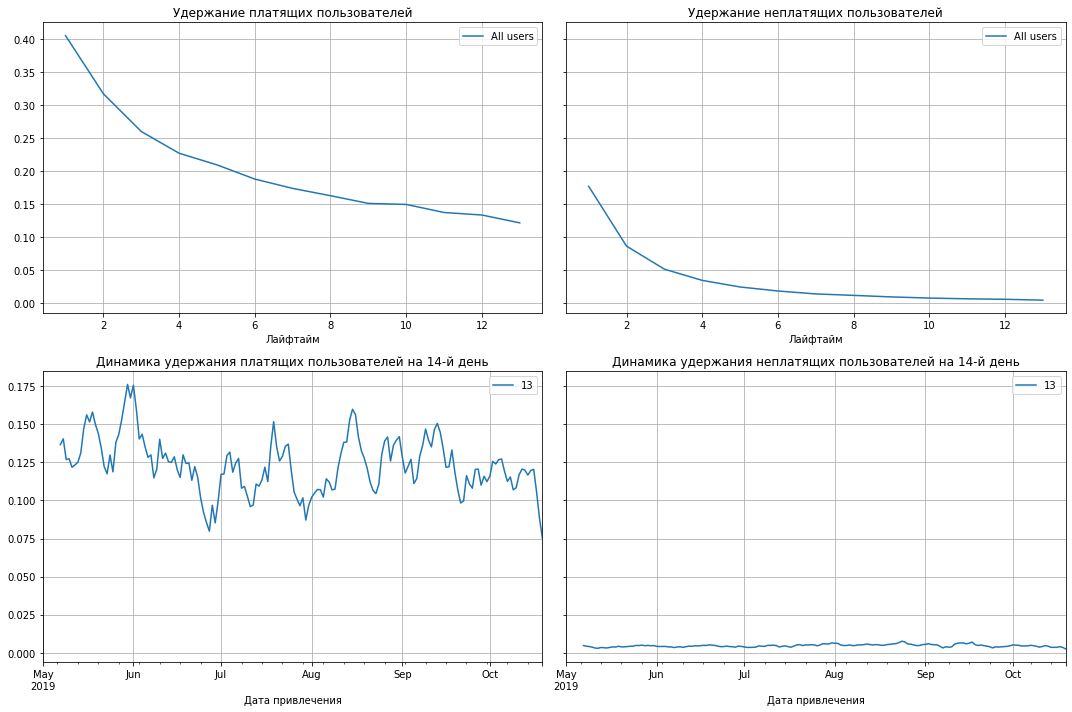

In [40]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days)
plot_retention(retention, retention_history, horizon_days)

Удержание платящих пользователей не снижается ниже 12% в конце двух недель. Удержание неплатящих приближается к нулю уже на 6 лайфтайм. В динамике на 14 день среди платящих пользователей лучше всего себя показала когорта начала июня, хуже всего когорта конца октября. Динамика неплатящих пользователей остается практически без изменений.

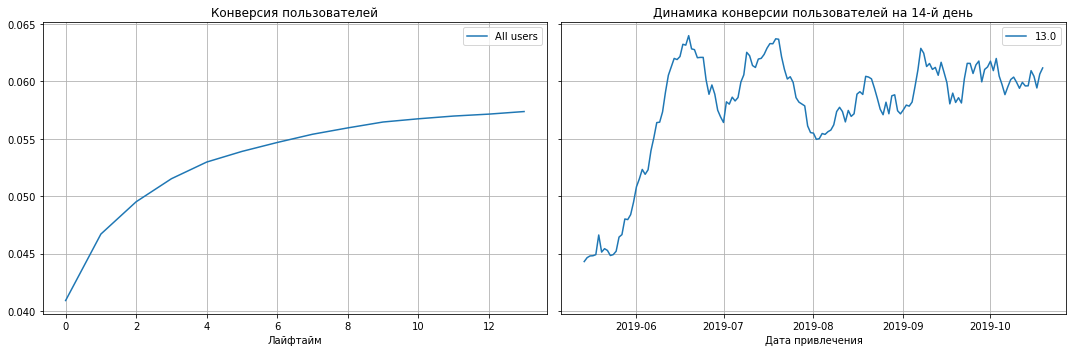

In [41]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей к концу двух недель достигла примерно 5.75%. В динамике самая большая конверсия была в середине июня и середине июля.

In [42]:
ltv_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, datetime(2019,11,1).date(), 14, dimensions=['device'])

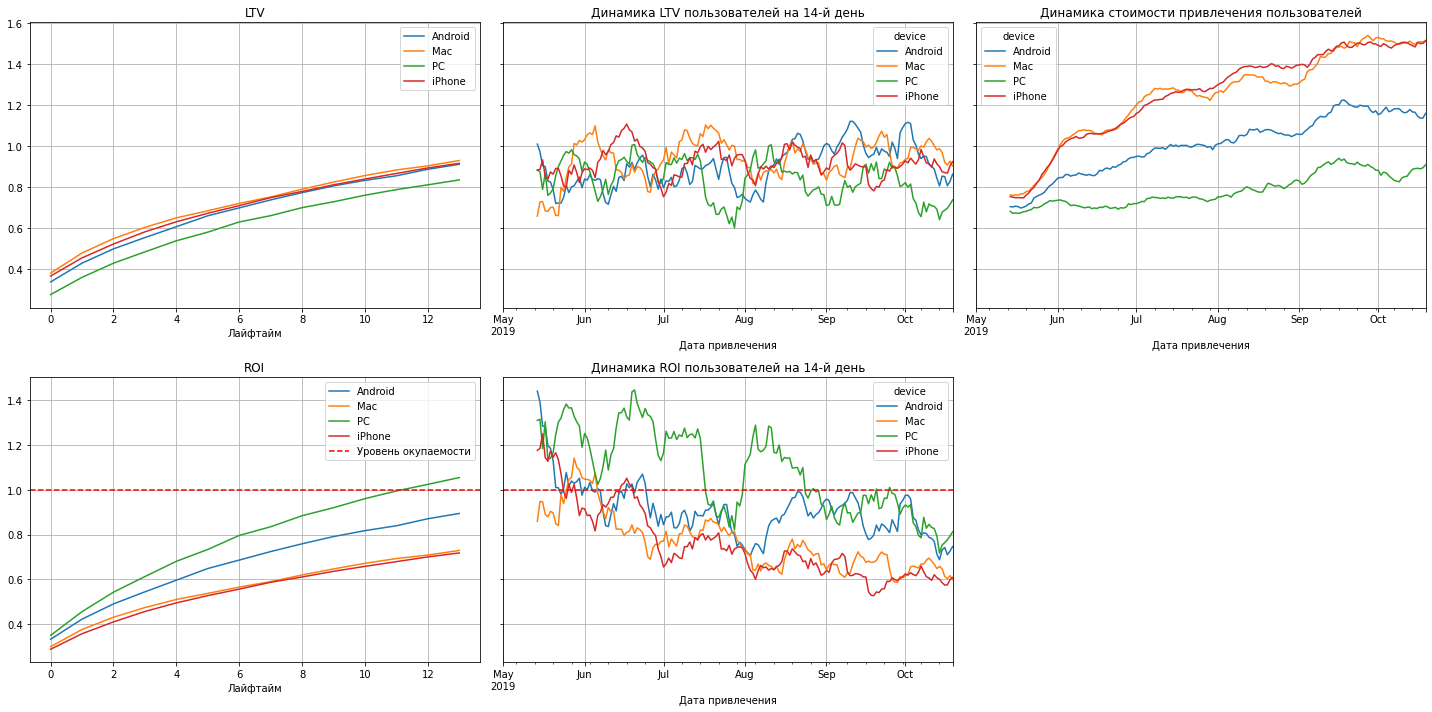

In [43]:
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, horizon_days, window=14)

Окупиться смогли только пользователи приложения на ПК, другие устройства не смогли, несмотря на то, что на ПК было потрачено меньше всего рекламных средств. Android окупились только на 90%, iPhone и Mac только на 70%. В динамике окупаемость ПК так же проявляет себя лучше, но LTV ПК самая низкая.

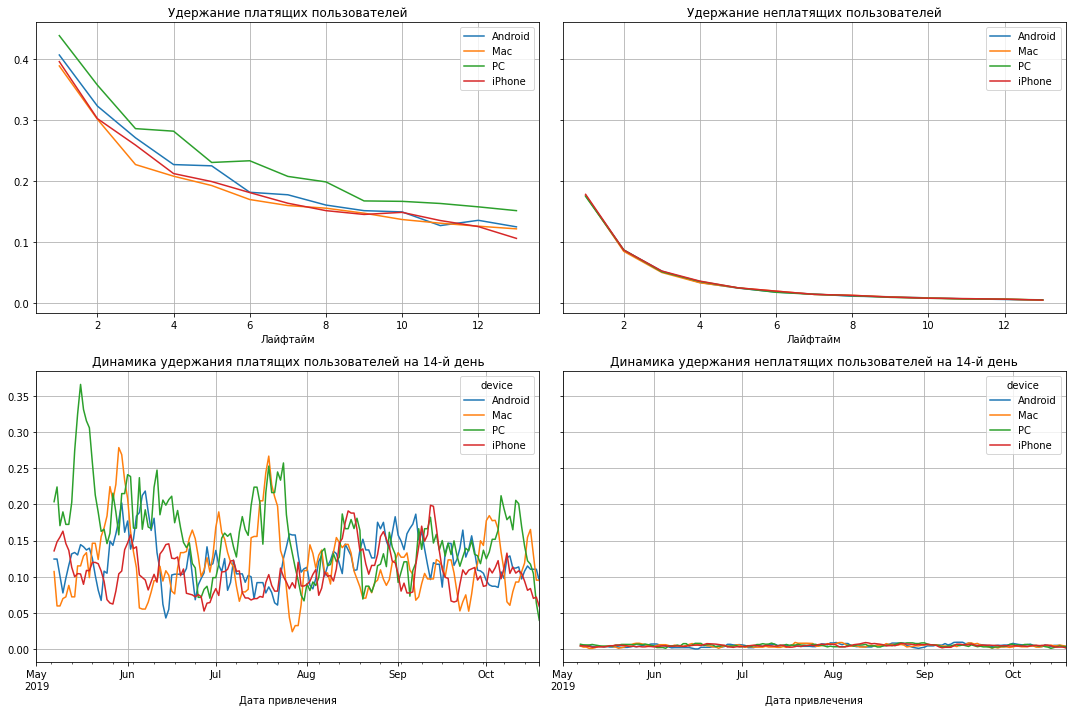

In [44]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, dimensions=['device'])
plot_retention(retention, retention_history, horizon_days)

Пользователи ПК удерживаются лучше по сравнению с другими устройствами. Динамика 14-го дня так же указывает, что удержание пользователей ПК довольно часто достигало самого высокого уровня.

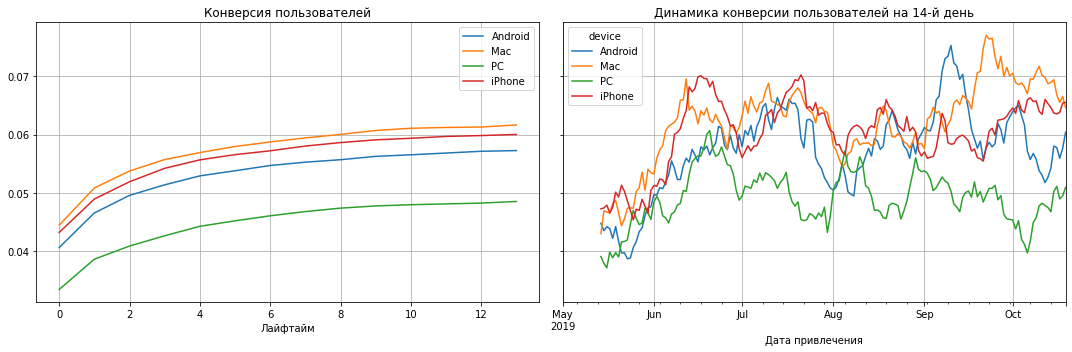

In [45]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи ПК конвертируются хуже. В конце двух недель она составила около 5%, другие платформы оказались успешнее. Конверсия пользователей Mac составила примерно 6.1%. Это так же подтверждается и на графике динамики 14-го дня.

In [46]:
ltv_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, 14, dimensions=['region'])

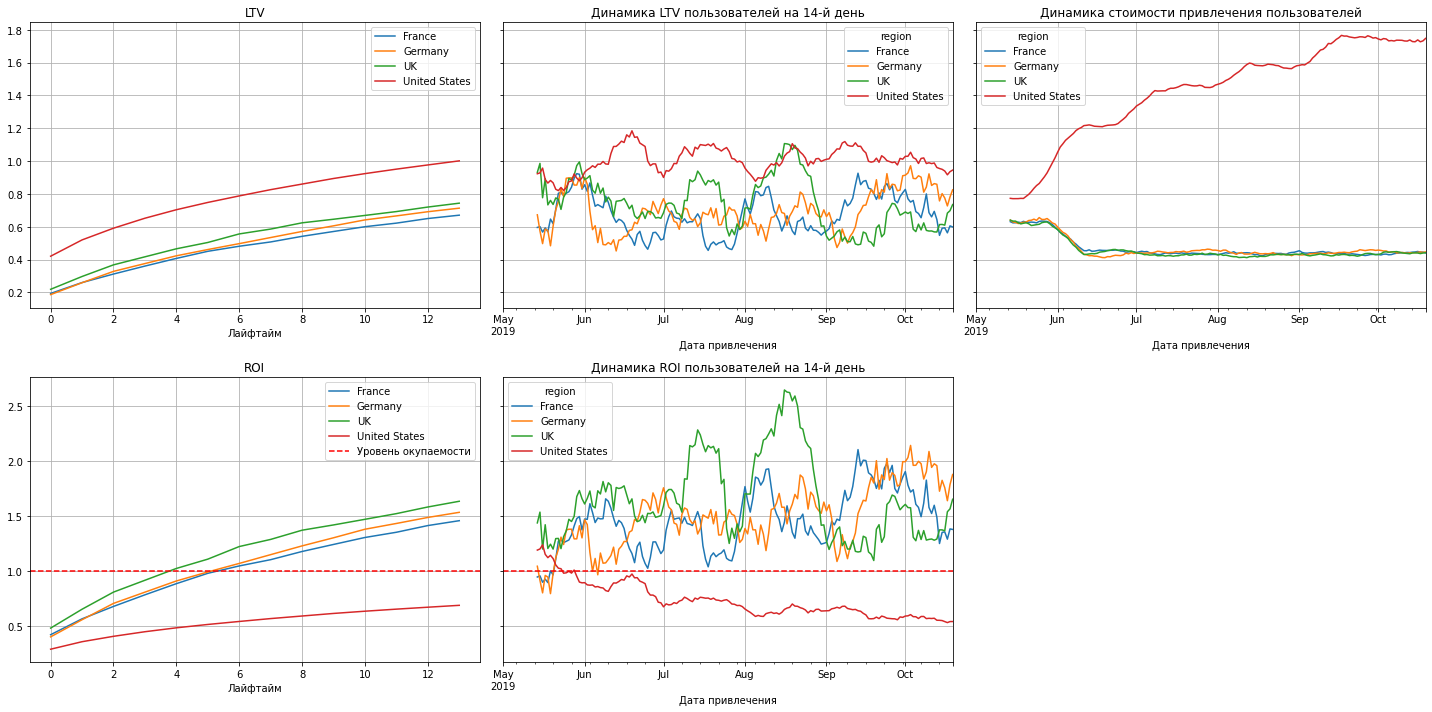

In [47]:
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, 14, window=14)

Сразу бросается в глаза то, что динамика стоимости привлечения пользователей из США оказалась самой высокой, а окупаемость данных пользователей достигла отметки в 65%. В то время, как расходы на рекламу в других странаха сократились, окупаемость пользователей из этих стран достигла 150%. Стоит отметить, что LTV пользователей из США является самым высоким, поэтому можно понять стремление вложить как можно больше средств в рекламу именно в США. Тем не менее, динамика ROI 14-го дня так же указывает, что пользователи из США окупались только до конца мая, после чего окупаемость продолжала падать ло самого конца анализируемого периода.

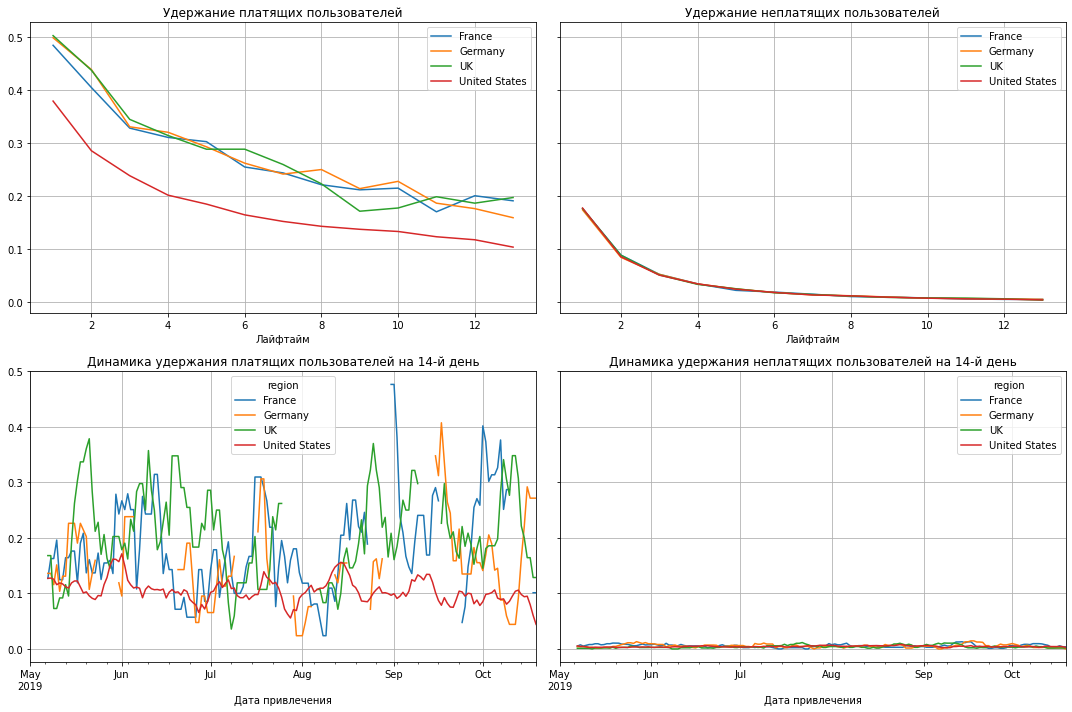

In [48]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, dimensions=['region'])
plot_retention(retention, retention_history, horizon_days)

Удержание платящих клиентов из США оказалось самым низким, к концу двух недель оно дисгло 10%. Динамика удержания 14-го дня для США является довлольно стабильной и держится на уровне 10%. У других стран разброс в разы больше.

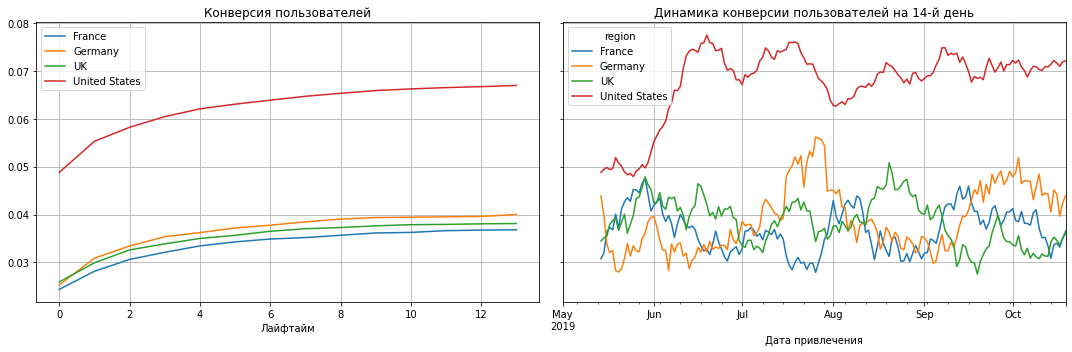

In [49]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

С другой стороны, конверсия пользователей из США является самой высокой и достигает 6.8%. Показатели других стран находятся на отметке примерно 4%. Динамика конверсии 14-го дня для США увеличилась с начала июня и продержалась на высокой отметке до конца анализируемого периода.

In [50]:
ltv_raw, ltv, ltv_dynamic, roi, roi_dynamic = get_ltv(profiles, orders, observation_date, 14, dimensions=['channel'])

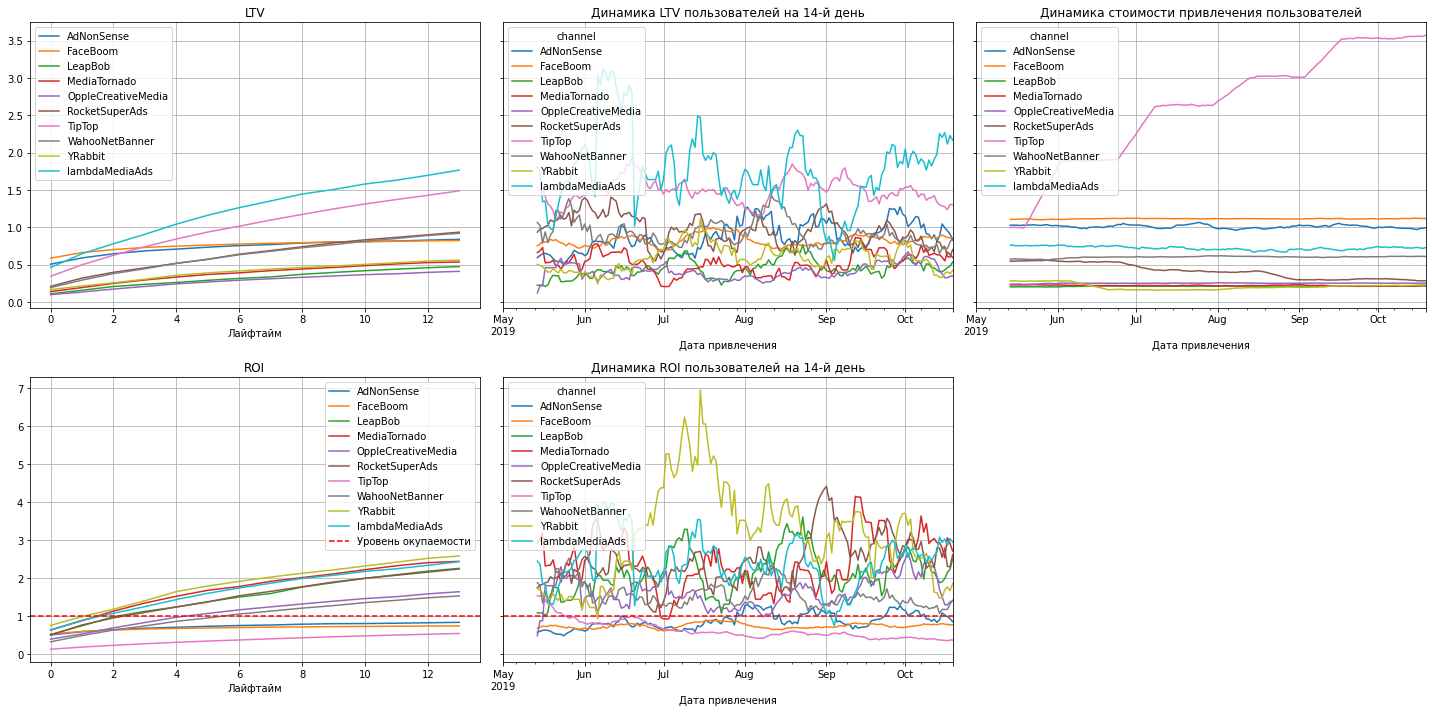

In [51]:
plot_ltv_roi(ltv, ltv_dynamic, roi, roi_dynamic, 14, window=14)

Динамика стоимости привлечения пользователей через TipTop крайне нестабильна и сильно возрастает. Более того, пользователи данного источника не окупаются до конца. Затраты на другие источники не такие высокие. с точки зрения окупаемости хуже всего себя показывают самые крупные платформы TipTop и FaceBoom. Заметна высокая LTV TipTop и менее популярного источника LambdaMediaAds. Динамика последней особенно высока. 

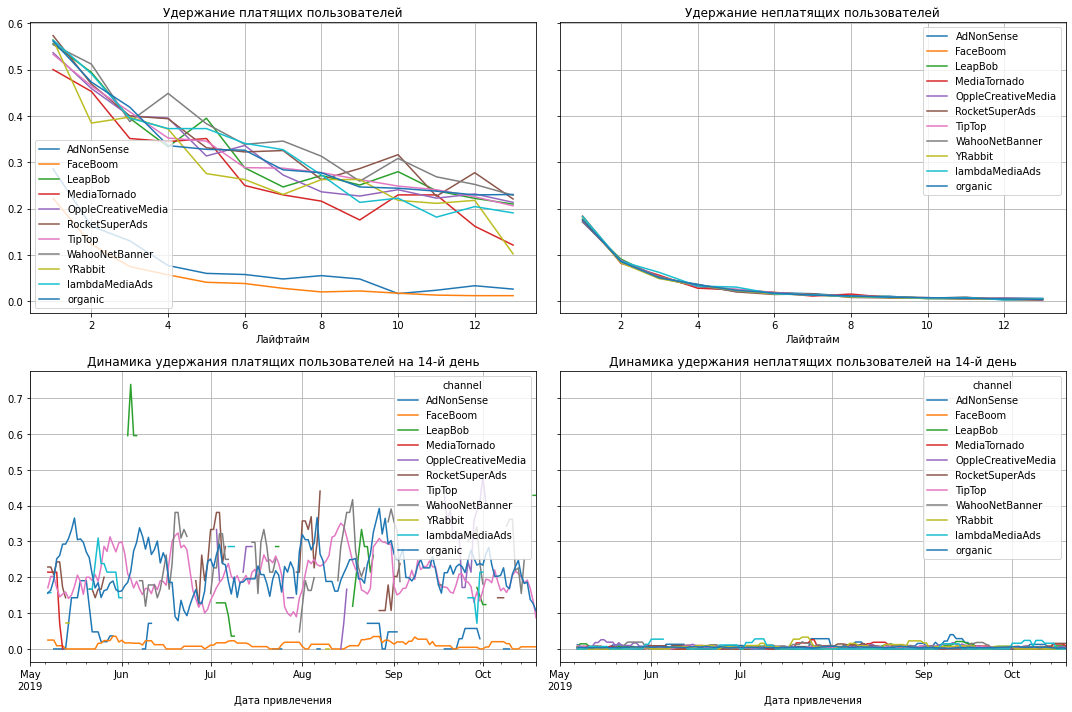

In [52]:
retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, horizon_days)

Хуже всего удерживаются пользователи, пришедшие самостоятельно и пришедшие из FaceBoom. Другие источники ведут себя похожим образом и большинство останавливается на 20%. YRabbit падает до 10%. Динамика так же указывает на стабильно низкое удержание пользователей FaceBoom.

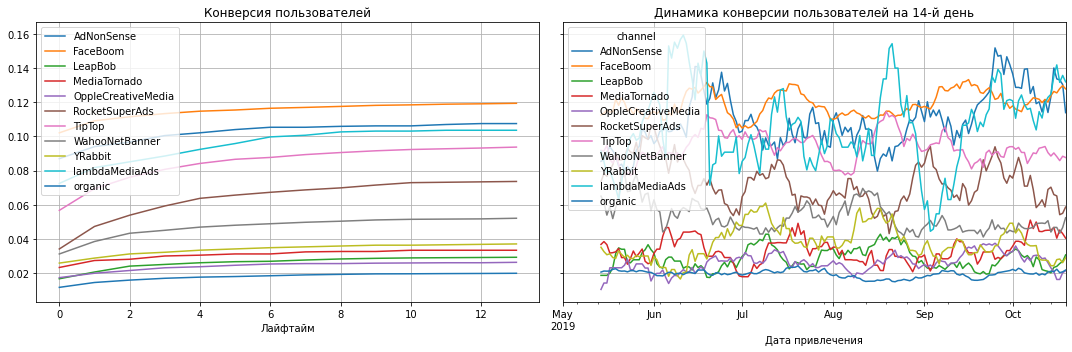

In [53]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Крайне низкой является конверсия органических пользователей, только 2%. Лучше всего конвертируются пользователи из FaceBoom - 12%, TiTop достиг отметки в 9%. LambdaMediaAds показывается результаты лучше, чем TipTop. Это подтверждается и на графике динамики конверсии.

**Вывод:** Пользователи успевают окупиться только на 80%, удержание в конце двух недель равна 12%, конверсия - 5.75%. В разделении по устройствам выделяется ПК. Это единственное устройство, которое окупается, при этом затраты на рекламу самые маленькие. При разделении по странам можно заметить, что затраты на привлечение пользователей из США очень высоки, при этом их окупаемость достигает только 65%. При этом LTV и конверсия пользователей из США самые высокие. Вдобавок, при разделении по каналам привлечения пользователей заметен сильный рост стоимости привлечения пользователей через "TipTop". Пользователи привлеченные через данный канал окупаются только на 70%. При этом их конверсия не самая высокая, а удержание соответсвует другим каналам.

## Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.



В ходе исследования мы анализировали период с 1-го мая 2019 по 27 октября 2019 года. Мы выяснили, что в общем и целом пользователи окупаются только на 80%, к концу двух недель удержание составляет 12%, а конверсия 5.75%. 

Большая часть пользователей использует мобильные устройства для доступа к приложению, тем не менее на рекламу устройств Apple уходят значительные средства, но реклама не успевает окупаться за две недели. В этом случае возможным решение будет перераспредление средств на устройства Android, которые ближе всего к окупаемости, если сравнивать с девайсами Apple, а LTV не отстает от них. С другой стороны, наиболее надежным устройством является ПК, так как данное устройство обладает самым высоким удержанием и является единственным, реклама которого окупается. При этом средст на рекламу ПК тратится меньше всего, даже несмотря на то, что конверсия и LTV ниже других устройств. Еще одним возможным вариантом повышения прибыльности приложения является увеличение средств на привлечение пользователей ПК.

Вдобавок, большое количество средств уходит на привлечение пользователей из США. Это обусловлено тем, что США является самым большим и прибыльным рынком. Однако, привлечение данных пользователей не окупается и останавливается на отметке в 65%. Удержание пользователей данной категории является самым низким, что может быть одной из причин убытков компании. В такой ситуации можно попыться найти способ увеличить удержание клиентов из США, что может повлиять на все оновные показатели. Также, может быть разумно сменить источник привлечения клиентов на то, что не требует таких объемов средств и будет более эффективным.
В частности, источник "TipTop" требует больших средств и при этом не успевает окупиться до конца двух недель. На его фоне заметно выделяется LambdaMediaAds. Данный источник превосходит TipTop по LTV, окупается уже на второй лайфтайм, превосходит по конверсии, уступая только FaceBoom и еще одному источнику. При этом затраты заметно меньше, чем на TipTop. Можно отметить источник Yrabbit. Пользователи привлеченны через данный канал окупаются быстрее всего, это также видно и в динамике окупаемости 14-го дня. Тем не менее пожизненная ценность подобных пользователей одна из самых низких. Показатели удержания и конверсии так же одни из самых низких среди каналов. С другой стороны затраты на привлечение для этого канала крайне малы. В связи с этим можно предполо